In [13]:
# ==============================================================================
#                 Random Selection Baseline Experiment
# ------------------------------------------------------------------------------
# This script establishes a baseline performance by using a purely random
# test case selection strategy. It runs the selection process 30 times for
# each budget level to gather robust statistical data on the performance of
# a naive approach.
# ==============================================================================

import pandas as pd
import numpy as np
import random
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
from openpyxl import Workbook
from openpyxl.drawing.image import Image as OpenpyxlImage
from io import BytesIO

# --- CONFIGURATION FOR THE EXPERIMENT ---
BUDGET_PERCENTAGES = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
NUM_RUNS_PER_BUDGET = 30

print("Setup complete. Ready to run the random selection baseline.")

Setup complete. Ready to run the random selection baseline.


In [14]:
# ======================================================
# Cell 2: Load Data and Define the Algorithm
# ======================================================

print("Please upload the 'mapped_dataset' file you wish to analyze (e.g., default-size or half-size).")
uploaded = files.upload()

if not uploaded:
    print("\nNo file uploaded. Aborting.")
else:
    filename = next(iter(uploaded))
    print(f"\nSuccessfully uploaded '{filename}'")

    # --- Load and process the dataset ---
    df = pd.read_excel(filename)

    # Create necessary lookup maps
    req_sets = df.groupby('tc_id')['us_id'].apply(set).to_dict()
    costs = df.groupby('tc_id')['tc_executiontime'].first().to_dict()
    bvalue = df.groupby('us_id')['us_businessvalue'].first().to_dict()

    all_tests = sorted(list(costs.keys()))
    num_total_reqs = df['us_id'].nunique()
    total_exec_time = sum(costs.values())

    print(f"Data loaded: {len(all_tests)} Test Cases, {num_total_reqs} Requirements.")
    print(f"Total possible execution time: {total_exec_time:.2f}")

    def run_random_selection(budget, tests_to_select, cost_map, req_map):
        """
        Selects test cases in a random order until the budget is met.
        """
        random.shuffle(tests_to_select)

        selected_tests = []
        current_cost = 0

        for test_id in tests_to_select:
            test_cost = cost_map.get(test_id, 0)
            if current_cost + test_cost <= budget:
                selected_tests.append(test_id)
                current_cost += test_cost
            else:
                # Cannot afford the next test, so we stop
                pass

        # Calculate final metrics for this run
        covered_reqs = set().union(*(req_map.get(t, set()) for t in selected_tests))
        req_coverage_pct = (len(covered_reqs) / num_total_reqs) * 100 if num_total_reqs > 0 else 0
        total_bv_covered = sum(bvalue.get(r, 0) for r in covered_reqs)

        return req_coverage_pct, total_bv_covered

Please upload the 'mapped_dataset' file you wish to analyze (e.g., default-size or half-size).


Saving mapped_dataset_1.xlsx to mapped_dataset_1 (3).xlsx

Successfully uploaded 'mapped_dataset_1 (3).xlsx'
Data loaded: 40 Test Cases, 124 Requirements.
Total possible execution time: 349.65



--- Starting Random Selection (30 runs per budget) ---

Running for Budget: 5% (Max Time: 17.48)
  Run 30/30...
  -> Completed 30 runs.

Running for Budget: 10% (Max Time: 34.96)
  Run 30/30...
  -> Completed 30 runs.

Running for Budget: 15% (Max Time: 52.45)
  Run 30/30...
  -> Completed 30 runs.

Running for Budget: 20% (Max Time: 69.93)
  Run 30/30...
  -> Completed 30 runs.

Running for Budget: 25% (Max Time: 87.41)
  Run 30/30...
  -> Completed 30 runs.

Running for Budget: 30% (Max Time: 104.89)
  Run 30/30...
  -> Completed 30 runs.

Running for Budget: 35% (Max Time: 122.38)
  Run 30/30...
  -> Completed 30 runs.

Running for Budget: 40% (Max Time: 139.86)
  Run 30/30...
  -> Completed 30 runs.

Running for Budget: 45% (Max Time: 157.34)
  Run 30/30...
  -> Completed 30 runs.

Running for Budget: 50% (Max Time: 174.82)
  Run 30/30...
  -> Completed 30 runs.

Running for Budget: 55% (Max Time: 192.31)
  Run 30/30...
  -> Completed 30 runs.

Running for Budget: 60% (Max Time: 2

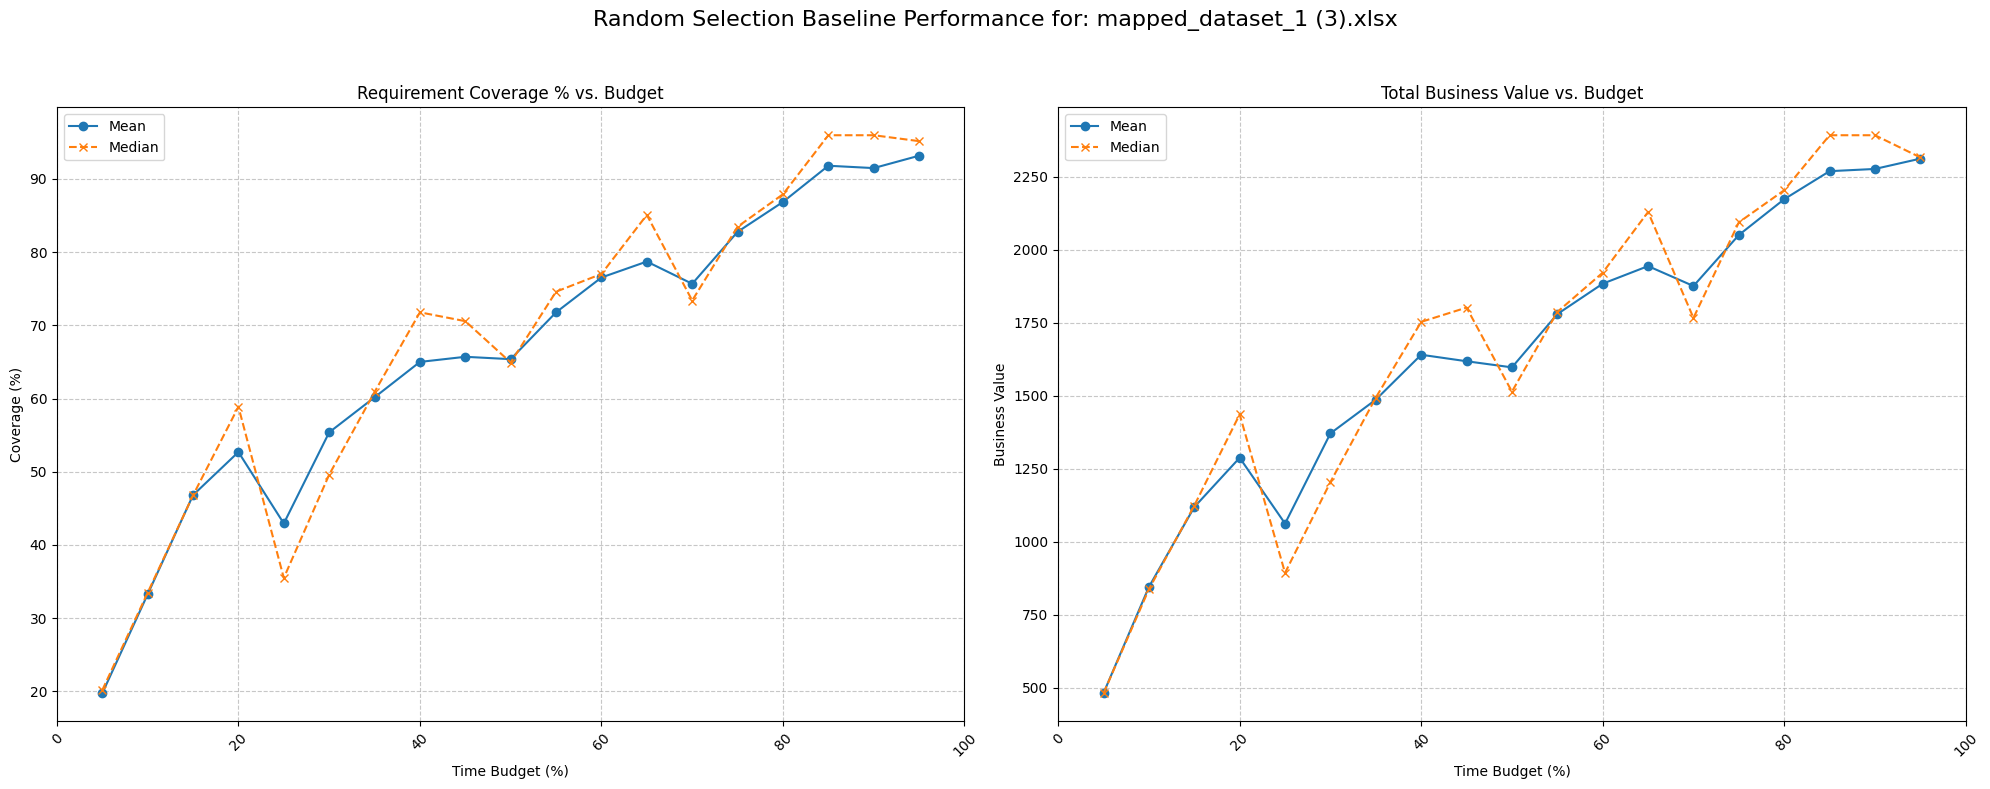


Generating report: 'Random_Selection_Report_1 (3).xlsx'
Report saved successfully. You can now download it.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
# ======================================================
# Cell 3: Run Experiment and Generate Report
# ======================================================

if 'df' in locals():
    all_run_data = []

    print(f"\n--- Starting Random Selection ({NUM_RUNS_PER_BUDGET} runs per budget) ---")

    for pct in BUDGET_PERCENTAGES:
        budget = (pct / 100.0) * total_exec_time
        print(f"\nRunning for Budget: {pct}% (Max Time: {budget:.2f})")

        for run in range(NUM_RUNS_PER_BUDGET):
            print(f"  Run {run + 1}/{NUM_RUNS_PER_BUDGET}...", end='\r')

            # Create a fresh copy of the test list for shuffling
            tests_to_shuffle = list(all_tests)

            req_cov, total_bv = run_random_selection(budget, tests_to_shuffle, costs, req_sets)

            all_run_data.append({
                'budget_pct': pct,
                'run': run + 1,
                'req_coverage_pct': req_cov,
                'total_business_value': total_bv
            })
        print(f"\n  -> Completed {NUM_RUNS_PER_BUDGET} runs.")

    # --- Analysis and Reporting ---
    raw_results_df = pd.DataFrame(all_run_data)

    summary_df = raw_results_df.groupby('budget_pct').agg(
        mean_req_cov=('req_coverage_pct', 'mean'),
        median_req_cov=('req_coverage_pct', 'median'),
        mean_bv=('total_business_value', 'mean'),
        median_bv=('total_business_value', 'median')
    ).reset_index()

    print("\n\n" + "="*60)
    print("--- Final Statistical Summary for Random Selection ---")
    print(summary_df.to_string())
    print("="*60)

    # --- Generate Plots ---
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle(f'Random Selection Baseline Performance for: {filename}', fontsize=16)

    axes[0].plot(summary_df['budget_pct'], summary_df['mean_req_cov'], marker='o', label='Mean')
    axes[0].plot(summary_df['budget_pct'], summary_df['median_req_cov'], marker='x', linestyle='--', label='Median')
    axes[0].set_title('Requirement Coverage % vs. Budget'); axes[0].set_ylabel('Coverage (%)'); axes[0].legend()

    axes[1].plot(summary_df['budget_pct'], summary_df['mean_bv'], marker='o', label='Mean')
    axes[1].plot(summary_df['budget_pct'], summary_df['median_bv'], marker='x', linestyle='--', label='Median')
    axes[1].set_title('Total Business Value vs. Budget'); axes[1].set_ylabel('Business Value'); axes[1].legend()

    for ax in axes.flat:
        ax.set_xlabel('Time Budget (%)'); ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_xlim(0, 100); ax.tick_params(axis='x', rotation=45)
    plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.show()

    # --- Create Final Excel Report ---
    report_suffix = filename.replace('mapped_dataset_', '').replace('.xlsx', '')
    output_excel_filename = f"Random_Selection_Report_{report_suffix}.xlsx"
    print(f"\nGenerating report: '{output_excel_filename}'")

    img_buffer = BytesIO(); fig.savefig(img_buffer, format='png'); img_buffer.seek(0)

    with pd.ExcelWriter(output_excel_filename, engine='openpyxl') as writer:
        raw_results_df.to_excel(writer, sheet_name='Raw Run Data', index=False)
        summary_df.to_excel(writer, sheet_name='Summary Table', index=False)
        ws = writer.book.create_sheet(title="Performance Plots")
        ws.add_image(OpenpyxlImage(img_buffer), 'A1')

    print(f"Report saved successfully. You can now download it.")
    files.download(output_excel_filename)

else:
    print("\nCannot run experiment. Please upload a file in Cell 2.")